# 使用运动的照相机重建三维场景

In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
import matplotlib
import cv2
import numpy as np
from PIL import Image

下面是从http://cvlabwww.epfl.ch/data/multiview/denseMVS.html 下载的两幅使用同一个照相机从不同角度拍摄的两幅照片。该网站提供了照相机矩阵为：

```
2759.48 0 1520.69 
0 2764.16 1006.81 
0 0 1 
```

由于这里的图片是网站上图片的1/4大小，因此将照相机矩阵中所有的数值都除以4。

In [2]:
A = np.array([[2759.48/4, 0, 1520.69/4, 0, 2764.16/4,1006.81/4, 0, 0, 1]]).reshape(3, 3)
d = np.array([0.0, 0.0, 0.0, 0.0, 0.0]).reshape(1, 5)
img1 = cv2.imread("0004.png")
img2 = cv2.imread("0005.png")

下面首先通过`FastFeatureDetector_create()`创建一个搜寻特征点的对象，并寻找第一幅图像中的特征点。

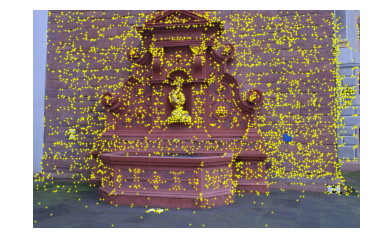

In [3]:
fast = cv2.FastFeatureDetector_create()
points = fast.detect(img1, None)
points1 = np.array([p.pt for p in points], dtype=np.float32)

pl.imshow(img1[:, :, ::-1])
pl.plot(points1[:, 0], points1[:, 1], "s", color="yellow", alpha=0.5, ms=1)
pl.axis("off");

下面使用光流算法函数`calcOpticalFlowPyrLK()`在`img2`中找到与`img1`中坐标为`points1`的点对应的坐标。它返回三个数组`points2, status, err`，只有`status`为1，并且`err`足够小的点才是有效的，可以使用这两个数组剔除失败的点。

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


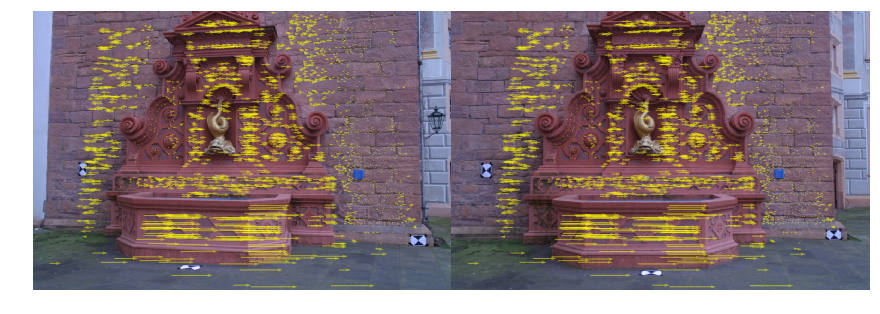

In [4]:
points2, status, err = cv2.calcOpticalFlowPyrLK(img1, img2, points1, np.zeros_like(points1))
mask = ((err < 5) & (status == 1)).ravel()
matched_points1 = points1[mask, :]
matched_points2 = points2[mask, :]

pl.figure(figsize=(15, 6))
pl.imshow(np.concatenate([img1[:, :, ::-1], img2[:, :, ::-1]], axis=1))
x1, y1 = matched_points1.T
x2, y2 = matched_points2.T
kw = dict(angles="xy", scale_units="xy", scale=1, color="yellow", units="dots", width=1, alpha=0.5)
pl.quiver(x1, y1, x2 - x1, y2 - y2, **kw)
pl.quiver(x1+img1.shape[1], y1, x2 - x1, y2 - y2, **kw)
pl.axis("off");

然后就可以使用[OpenCV照相机三维重建.ipynb](OpenCV照相机三维重建.ipynb)中介绍的方法通过Essential矩阵计算旋转偏移矩阵，从而计算三维空间中的点的坐标。调用`findEssentialMat()`时使用`FM_RANSAC`算法，它能有效地剔除干扰数据。

In [5]:
E, Emask = cv2.findEssentialMat(matched_points1, matched_points2, A, cv2.FM_RANSAC, 0.02)
Emask = Emask.ravel() == 1
matched2_points1 = matched_points1[Emask]
matched2_points2 = matched_points2[Emask]

调用`recoverPose()`通过Essential矩阵计算旋转偏移矩阵。

In [6]:
ret, R, t, mask = cv2.recoverPose(E, matched2_points1, matched2_points2, A)
R, t

(array([[  9.80025777e-01,   2.50387291e-04,  -1.98870346e-01],
        [ -1.40404270e-03,   9.99982996e-01,  -5.66004449e-03],
        [  1.98865547e-01,   5.82621196e-03,   9.80009464e-01]]),
 array([[ 0.99880882],
        [ 0.02773247],
        [-0.04014783]]))

调用`triangulatePoints()`重建三维场景时需要注意，它的两组点的坐标必须是正规化之后的像素坐标。可以使用$\mathbf{y} = \mathbf{A}^{-1} \mathbf{x}$计算。这里$\mathbf{A}$是照相机矩阵，$\mathbf{x}$是像素坐标，$\mathbf{y}$是正规化之后的像素坐标。

In [11]:
def normalize(p, A):
    return np.linalg.inv(A) @ np.c_[p, np.ones(len(p))].T

points4d = cv2.triangulatePoints(
    np.c_[np.eye(3), np.zeros(3)], 
    np.c_[R, t],
    normalize(matched2_points1, A)[:2],
    normalize(matched2_points2, A)[:2])

points4d /= points4d[-1]

最后使用Plotly绘制点云。

In [9]:
from plotlyhelp import init_plotly_online_mode, plot_points
init_plotly_online_mode()

In [10]:
plot_points(points4d[:3])